### To do
- faire une PCA

In [291]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from sklearn.preprocessing import Imputer, StandardScaler, MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, f1_score, r2_score
from sklearn.metrics import auc, confusion_matrix

### Loading the data

In [369]:
raw = pd.read_excel('data/dataframe_elections.xlsx')
print('Taille initiale du DF :', raw.shape)

# Données d'identification
id_list = ['an', 'dep', 'circo', 'code', 'nom', 'prenom', 'nuance_groupe', 'taux_vote_leg', 'second_tour']
df_id = raw[id_list]

# drop colonnes
drop_list = ['dep', 'circo', 'c_dep', 'code', 'inscrits', 'circo_parti', 'circo_nuance',
             'nom', 'prenom', 'etiquette', 'nuance', 'voix', 'second_tour']
raw = raw.drop(drop_list, axis=1)

print('Taille du DF après retrait des colonnes inutiles :', raw.shape)

Taille initiale du DF : (36919, 81)
Taille du DF après retrait des colonnes inutiles : (36919, 68)


In [381]:
def generate_df(raw_data, keep_list, penalty=.8):
    # à garder obligatoirement pour identifier les lignes et créer les labels
    keep_nuance = 'nuance_groupe' in keep_list
    keep_list.extend(['an', 'nuance_groupe', 'p_inscrits', 'p_exprimes'])

    df = raw_data.drop([col for col in raw_data.columns if col not in keep_list], axis=1)
    #print(df.columns)

    # Gestion des NaN au niveau du score du candidat aux législatives précédentes
    years = [2002, 2007, 2012, 2017]
    partis = ['EXG', 'COM', 'FI', 'DVG', 'ECO', 'SOC', 'RDG', 'MDM',
              'UDI', 'DVD', 'LR', 'DLF', 'FN', 'EXD', 'REG', 'DIV']
    
    # TODO : POUR LES CANDIDATS "EN MARCHE", PAR QUOI REMPLIR LE SCORE DES CANDIDATS A LA PREC LEG ?
    
    if 'score_candidat_prec_leg_ins' in keep_list:
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_inscrits'][mask_2]) * penalty # moyenne des voix du parti 5 ans avant (% d'inscrits)
                df.loc[mask, 'score_candidat_prec_leg_ins'] = df['score_candidat_prec_leg_ins'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_inscrits) * penalty
        df.score_candidat_prec_leg_ins = df.score_candidat_prec_leg_ins.fillna(value=mean)
        
    if 'score_candidat_prec_leg_expr' in keep_list:
        for parti in partis:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(parti))
            for year in years:
                mask = (df['an']==year) & (df['nuance_groupe']==parti)
                mask_2 = (df['an']==year - 5) & (df['nuance_groupe']==parti)
                mean = np.mean(df['p_exprimes'][mask_2]) * penalty # moyenne des voix du parti 5 ans avant (% exprimés)
                df.loc[mask, 'score_candidat_prec_leg_expr'] = df['score_candidat_prec_leg_expr'][mask].fillna(value=mean)
                #print('La moyenne du parti en {} est {:.2f}%'.format(year - 5, mean * 100))

        mean = np.mean(df.p_exprimes)
        df.score_candidat_prec_leg_expr = df.score_candidat_prec_leg_expr.fillna(value=mean)

    # Gestion des NaN : Autres variables. Remplacement des valeurs manquantes par la moyenne nationale
    features_a_completer = ['chom_tot', 'chom_jeunes', 'chom_adultes', 'chom_seniors',
                           'p_agri', 'p_commercants', 'p_cadres', 'p_intermed', 'p_employes',
                           'p_ouvriers', 'd_brevet', 'd_bep', 'd_bac', 'd_sup']
    for feature in features_a_completer:
        if feature in keep_list:
            #print('\nRemplissage des valeurs manquantes pour {} :'.format(feature))
            for year in years:
                mask = (df['an']==year)
                mean = np.mean(df[feature][mask])
                #print('La moyenne de la feature pour {} est {:.2f}%'.format(year, mean * 100))
                df.loc[mask, feature] = df[feature][mask].fillna(value=mean)

    # Catégorisation
    if 'score_candidat_prec_leg_cat' in keep_list:
        if 'score_candidat_prec_leg_expr' in keep_list:
            df['score_candidat_prec_leg_cat'] = pd.cut(df['score_candidat_prec_leg_expr'],
                                                       bins=[-1, -.01, .05, .1, .15, .25, 1],
                                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])
        elif 'score_candidat_prec_leg_ins' in keep_list:
            df['score_candidat_prec_leg_cat'] = pd.cut(df['score_candidat_prec_leg_ins'],
                                                       bins=[-1, -.01, .05, .1, .15, .25, 1],
                                                       labels=['N/A', 'A', 'B', 'C', 'D', 'E'])

    df = df[df.an > 1997]
    df = df[df.nuance_groupe!='DIV'] # On retire les candidats "Divers" (pour l'entraînement ET la prédiction)
    if not keep_nuance:
        df = df.drop('nuance_groupe', axis=1)
    
    print('Format du dataframe :', df.shape)
    print(df.isnull().sum())
    
    return df

In [453]:
def train_val_splits(df, year_for_validation, target, scaler=MinMaxScaler()):
    # Liste des variables dummies et binaires pour les exclure de la normalisation
    dummies_list = ['bloc', 'sexe', 'an', 'p_inscrits', 'p_exprimes', 'dep', 'circo',
                    'geo_frontalier', 'geo_dom', 'geo_idf',
                    'circo_nuance_groupe', 'circo_bloc', 'nuance_groupe',
                    'circo_nuance_groupe_pres', 'circo_pres_meme_nuance', 'circo_meme_nuance_president',
                    'circo_leg_meme_nuance',
                    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre', 'membre_majorite',
                    #'nb_candidats_meme_bloc', 'nb_candidats_circo',
                    'score_candidat_prec_leg_cat'
                   ]
    scale_list = [col for col in df.columns if col not in dummies_list]

    print('Variables à normaliser', scale_list)
    df = pd.get_dummies(df, drop_first=True)
    
    drop_list = ['an', 'p_inscrits', 'p_exprimes']
    df_train = df[(df.an != 2017) & (df.an != year_for_validation)].dropna(how='any')
    y_train = df_train[target]
    X_train = df_train.drop(drop_list, axis=1)
    
    df_val = df[df.an == year_for_validation].dropna(how='any')
    y_val = df_val[target]
    X_val = df_val.drop(drop_list, axis=1)
    
    # Normalisation du dataframe
    X_train[scale_list] = scaler.fit_transform(X_train[scale_list])
    X_val[scale_list] = scaler.transform(X_val[scale_list])

    print('Format des ensembles de train et de validation :')
    print(X_train.shape, X_val.shape)
    
    return X_train, X_val, y_train, y_val

In [440]:
def get_classif(y_pred, y_val, id_val, target, strategy):
    from scipy.stats import rankdata
    
    res = pd.concat([id_val, pd.DataFrame(y_val)], axis=1, join='inner')
    res['prediction'] = y_pred
    res['ecart'] = y_pred - res[target]
    res['classement'] = 0
    res['qualif'] = 'N'
    
    for circo in set(res.code):
        # classement des candidats par circonscription
        res.loc[res.code==circo, 'classement'] = rankdata(-res.prediction[res.code==circo], method='ordinal')
        
        # normalisation des votes pour que la somme soit égale à 100%
        res.loc[res.code==circo, 'prediction'] /= np.sum(res.loc[res.code==circo, 'prediction'])
        
        if target=='p_exprimes':
            taux_E = 1
            taux_O = np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
        elif target=='p_inscrits':
            taux_E = 1 / np.float(res.loc[(res.code==circo) & (res.classement==1), 'taux_vote_leg'])
            taux_O = 1
            
        # simulation des qualifiés pour le second tour
        i = 1
        q = 0
        while True:
            #print(res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values)
            if (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_E >= .5:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'E'
                if strategy == 'O':
                    q += 1
                elif strategy == 'E':
                    break
            elif (res.loc[(res.code==circo) & (res.classement==i), 'prediction'].values) * taux_O >= .125:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            elif q < 2:
                res.loc[(res.code==circo) & (res.classement==i), 'qualif'] = 'O'
                q += 1
            else:
                break

            i += 1
    return res

In [441]:
def analyze_predictions(df_predictions, target):
    n = df_predictions.shape[0]
    print('Prédictions pour {} candidats.'.format(n))

    ecarts_absolus = abs(df_predictions.ecart)
    max_ecart = np.max(ecarts_absolus)
    grid = np.arange(max_ecart, step=.01)
    ecarts_grid = []

    for point in grid:
        ecarts_grid.append(np.sum(ecarts_absolus < point))

    print('La MAE est : {:.2f}%'.format(
            mean_absolute_error(df_predictions[target], df_predictions.prediction) * 100))
    print('La plus grosse erreur est : {:.2f}%'.format(max_ecart * 100))
    print('Le score r2 est : {:.2f}'.format(r2_score(df_predictions[target], df_predictions.prediction)))

    point_list = [.01, .02, .05, .1]
    ecart_list = [np.sum(ecarts_absolus < point) for point in point_list]

    plt.figure(1, figsize=(19, 3))
    plt.subplot(131)
    plt.plot(grid, ecarts_grid)
    for i in range(len(point_list)):
        plt.plot(point_list[i], ecart_list[i], 'ro')
        plt.text(point_list[i]+.005, ecart_list[i]-400, '{:.2f}%'.format(ecart_list[i]/n))

    plt.title('Nb d\'obs en dessous d\'un seuil d\'erreur')
    plt.xlabel('Seuils d\'erreur')

    plt.subplot(132)
    plt.hist(df_predictions['ecart'], bins=50)
    plt.title('Répartition globale des erreurs')

    # comparaison de la distribution des erreurs, parti par parti
    from scipy.stats import gaussian_kde
    plt.subplot(133)
    x_grid = np.arange(min(df_predictions['ecart']), max(df_predictions['ecart']), step=.01)

    nuances = {'FI': 'red','ECO': 'green', 'SOC': 'pink', 'MDM': 'orange', 'UDI': 'yellow',
               'LR': 'blue', 'DLF': 'darkblue', 'FN': 'black', 'REG': 'teal'}
    for nuance in nuances:
        n_pred = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['qualif']=='E')
                               | (df_predictions['qualif']=='O'))].shape[0]
        n_reel = df_predictions[(df_predictions['nuance_groupe']==nuance)
                                & ((df_predictions['second_tour']=='E')
                               | (df_predictions['second_tour']=='O'))].shape[0]
        print('{}: {} prédits | Réel {}'.format(nuance, n_pred, n_reel))
        try: # cas où le parti n'est pas représenté à l'élection prédite
            pdf = gaussian_kde(df_predictions['ecart'][df_predictions['nuance_groupe']==nuance],
                               bw_method=.9).evaluate(x_grid)
            plt.plot(x_grid, pdf, color=nuances[nuance], label=nuance, lw=2)
        except:
            pass

    plt.title('Répartition des erreurs selon le parti')
    plt.legend(loc='best')

    n_correct = np.sum(df_predictions.second_tour == df_predictions.qualif)
    print('\n{} prédictions correctes sur {} (soit {:.1f}%)'.format(n_correct, n, 100 * n_correct / n))

    print('\nMatrice de confusion. En colonne les classes prédites, en ligne les classes réelles.')
    cm = confusion_matrix(df_predictions.second_tour, df_predictions.qualif, labels=['E', 'O', 'N'])
    print(cm)

    f1_E = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='E', average='micro')
    print('Score F1 pour la classe E : {:.1f}%'.format(f1_E * 100))
    f1_O = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='O', average='micro')
    print('Score F1 pour la classe O : {:.1f}%'.format(f1_O * 100))
    f1_N = f1_score(df_predictions.second_tour, df_predictions.qualif, labels='N', average='micro')
    print('Score F1 pour la classe N : {:.1f}%'.format(f1_N * 100))
    plt.show()
    
    return

### Choix des paramètres

In [474]:
# Sélection des features
keep_list = [#'geo_frontalier', 'geo_dom', 'geo_idf',
    'part_impose', 'chom_tot', 'chom_jeunes', 'chom_adultes', 'chom_seniors',
    'p_agri', 'p_commercants', 'p_cadres', 'p_intermed', 'p_employes',
    'p_ouvriers', 'd_brevet', 'd_bep', 'd_bac', 'd_sup'
    'circo_leg_meme_nuance', 'circo_meme_nuance_president', 'circo_pres_meme_nuance',
    'nb_candidats_meme_bloc',
    'nb_candidats_circo',
    'score_nuance_groupe_pres',
    #'score_candidat_prec_leg_ins',
    'score_candidat_prec_leg_expr',
    #'score_candidat_prec_leg_cat',
    #'score_nuance_groupe_prec_leg', #(un peu mauvais)
    'score_bloc_pres',
    #'score_bloc_prec_leg', #(mauvais pour le score)
    #'nuance_groupe',
    #'taux_vote_pres', 'taux_vote_leg',
    'depute_sortant', 'ancien_depute', 'au_gouvernement', 'ancien_ministre',
    'membre_majorite',
    'sexe'
]

scaler = MinMaxScaler()
#scaler = StandardScaler()

# Prédire les score en % des voix exprimées ou % des inscrits sur les listes électorales
target_values = 'p_exprimes' # 'p_inscrits'
target_year = 2012

# Taux par lequel on multiplie les score à la législative précédente qui étaient à la base des N/A
penalty = .9

# si 'O' : on note les potentiels qualifiés dès le 1er tour mais on indique aussi le candidat arrivé 2ème
# si 'E' : si un candidat est classé 'E', ses concurrents sont automatiquement tous classés 'N'
strategy = 'O' 

In [475]:
df = generate_df(raw, keep_list, penalty=penalty)
X_train, X_val, y_train, y_val = train_val_splits(df, target_year, target_values, scaler)

Format du dataframe : (26396, 30)
an                                 0
part_impose                        0
chom_tot                           0
chom_jeunes                        0
chom_adultes                       0
chom_seniors                       0
p_agri                             0
p_commercants                      0
p_cadres                           0
p_intermed                         0
p_employes                         0
p_ouvriers                         0
d_brevet                           0
d_bep                              0
d_bac                              0
circo_pres_meme_nuance             0
circo_meme_nuance_president        0
score_nuance_groupe_pres           0
score_bloc_pres                    0
score_candidat_prec_leg_expr       0
depute_sortant                     0
ancien_depute                      0
au_gouvernement                    0
ancien_ministre                    0
membre_majorite                    0
nb_candidats_meme_bloc             0
nb_c

In [476]:
X_train.head(2)

,part_impose,chom_tot,chom_jeunes,chom_adultes,chom_seniors,p_agri,p_commercants,p_cadres,p_intermed,p_employes,...,score_bloc_pres,score_candidat_prec_leg_expr,depute_sortant,ancien_depute,au_gouvernement,ancien_ministre,membre_majorite,nb_candidats_meme_bloc,nb_candidats_circo,sexe_M
14488,0.546669,0.061475,0.111776,0.045283,0.075342,0.097015,0.308824,0.201044,0.732283,0.336585,...,0.087235,0.084493,0.0,0.0,0.0,0.0,0.0,0.222222,0.347826,1
14489,0.546669,0.061475,0.111776,0.045283,0.075342,0.097015,0.308824,0.201044,0.732283,0.336585,...,0.509611,0.504781,0.0,0.0,0.0,0.0,1.0,0.111111,0.347826,1


### Choix de modèle

In [477]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1, n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_val)
sorted(list(zip(rf.feature_importances_*100, X_train.columns)), reverse=True)

[(64.464465528265279, 'score_candidat_prec_leg_expr'),
 (12.576978525212128, 'membre_majorite'),
 (6.4632831107112656, 'score_nuance_groupe_pres'),
 (4.4079377947866254, 'score_bloc_pres'),
 (2.3204976309509577, 'depute_sortant'),
 (1.2322745232550307, 'nb_candidats_meme_bloc'),
 (1.0060284392552055, 'part_impose'),
 (0.84208632507262027, 'nb_candidats_circo'),
 (0.72001185460636041, 'd_bac'),
 (0.54806358354711415, 'd_brevet'),
 (0.51220747130064526, 'p_commercants'),
 (0.49473060754370174, 'circo_pres_meme_nuance'),
 (0.48206906608615635, 'p_employes'),
 (0.46673020589265302, 'chom_jeunes'),
 (0.44644332177398094, 'd_bep'),
 (0.42984309770323825, 'p_agri'),
 (0.39533979032346295, 'p_ouvriers'),
 (0.35663055298399371, 'p_intermed'),
 (0.34588526700168082, 'chom_adultes'),
 (0.329857586615319, 'chom_seniors'),
 (0.32442454769708623, 'p_cadres'),
 (0.28357198951372919, 'chom_tot'),
 (0.26769395476918106, 'sexe_M'),
 (0.2672629404038534, 'ancien_depute'),
 (0.010664628677614222, 'ancien_

In [462]:
# from sklearn.svm import SVR
# reg = SVR()
# reg.fit(X_train, y_train)
# y_pred = reg.predict(X_val)

In [478]:
from sklearn.neighbors import KNeighborsRegressor
for i in range(7, 8):
    reg = KNeighborsRegressor(n_neighbors=i, weights='distance', n_jobs=-1)
    reg.fit(X_train, y_train)
    y_pred_knn = reg.predict(X_val)
    print('{} voisins : {:.2f}%'.format(i, 100 * mean_absolute_error(y_pred_knn, y_val)))

7 voisins : 3.88%


In [464]:
from sklearn.neural_network import MLPRegressor
reg = MLPRegressor((50, 50), activation='relu', solver='adam', alpha=1e-5, batch_size=400,
                   learning_rate='adaptive', learning_rate_init=1e-3, max_iter=500, tol=1e-7, verbose=True,
                  power_t=.5, early_stopping=False)
reg.fit(X_train, y_train)
y_pred_mlp = reg.predict(X_val)

Iteration 1, loss = 0.04425690
Iteration 2, loss = 0.00280592
Iteration 3, loss = 0.00218473
Iteration 4, loss = 0.00193615
Iteration 5, loss = 0.00178005
Iteration 6, loss = 0.00168327
Iteration 7, loss = 0.00162177
Iteration 8, loss = 0.00157598
Iteration 9, loss = 0.00154185
Iteration 10, loss = 0.00151087
Iteration 11, loss = 0.00148261
Iteration 12, loss = 0.00146574
Iteration 13, loss = 0.00143871
Iteration 14, loss = 0.00141913
Iteration 15, loss = 0.00140572
Iteration 16, loss = 0.00139780
Iteration 17, loss = 0.00137890
Iteration 18, loss = 0.00136506
Iteration 19, loss = 0.00135627
Iteration 20, loss = 0.00134668
Iteration 21, loss = 0.00133385
Iteration 22, loss = 0.00132427
Iteration 23, loss = 0.00131476
Iteration 24, loss = 0.00130919
Iteration 25, loss = 0.00129627
Iteration 26, loss = 0.00128535
Iteration 27, loss = 0.00128514
Iteration 28, loss = 0.00127313
Iteration 29, loss = 0.00126283
Iteration 30, loss = 0.00125850
Iteration 31, loss = 0.00125245
Iteration 32, los

In [465]:
# Mix des prédictions des modèles
y_pred = np.mean(np.array([y_pred_rf,
                           y_pred_knn,
                          y_pred_mlp]), axis=0)

Prédictions pour 6145 candidats.
La MAE est : 3.69%
La plus grosse erreur est : 58.84%
Le score r2 est : 0.80
ECO: 10 prédits | Réel 44
MDM: 9 prédits | Réel 12
FI: 21 prédits | Réel 12
SOC: 467 prédits | Réel 437
LR: 486 prédits | Réel 433
FN: 70 prédits | Réel 59
DLF: 1 prédits | Réel 1
REG: 2 prédits | Réel 4
UDI: 31 prédits | Réel 45

5709 prédictions correctes sur 6145 (soit 92.9%)

Matrice de confusion. En colonne les classes prédites, en ligne les classes réelles.
[[  10   25    1]
 [  58  882  161]
 [   0  191 4817]]
Score F1 pour la classe E : 19.2%
Score F1 pour la classe O : 80.2%
Score F1 pour la classe N : 96.5%


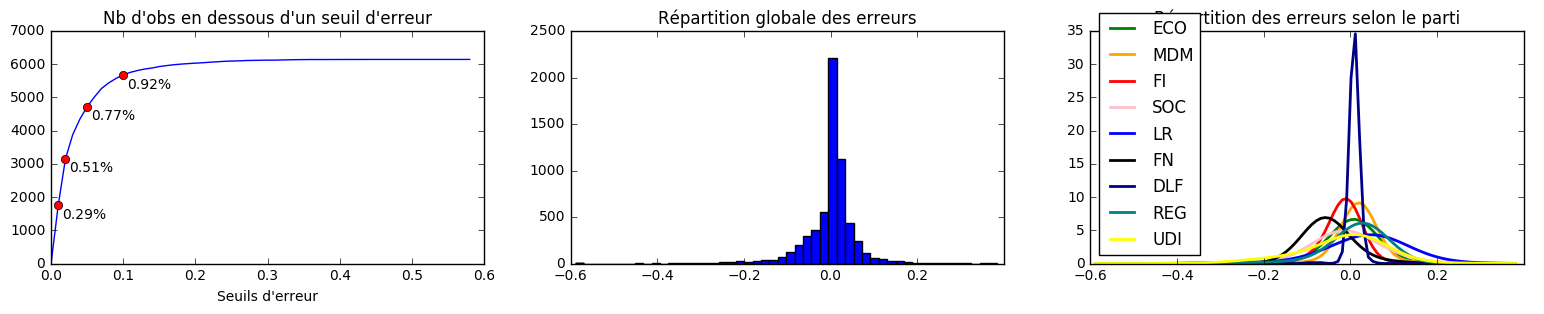

In [479]:
df_predictions = get_classif(y_pred_rf, y_val, df_id, target_values, strategy)
analyze_predictions(df_predictions, target_values)

In [429]:
df_predictions.sort_values(by='ecart').head(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
13113,2012,SAINT-PIERRE-ET-MIQUELON,1,975|1,GIRARDIN,ANNICK,RDG,0.5186,E,0.6552,0.161500,-0.578711,4,N
12340,2012,PARIS,6,75|6,DUFLOT,CECILE,ECO,0.5929,O,0.4874,0.122457,-0.415166,2,O
12414,2012,PARIS,10,75|10,BAUPIN,DENIS,ECO,0.5834,O,0.4289,0.031735,-0.411267,9,N


In [430]:
df_predictions.sort_values(by='ecart').tail(3)

,an,dep,circo,code,nom,prenom,nuance_groupe,taux_vote_leg,second_tour,p_exprimes,prediction,ecart,classement,qualif
10990,2012,LA-REUNION,2,974|2,LOUGNON,LAURENCE,SOC,0.4562,N,0.0305,0.275513,0.315032,1,O
9493,2012,FRANCAIS-DE-L'ETRANGER,4,99|4,PAILLE,DOMINIQUE,UDI,0.2385,N,0.0281,0.270915,0.338516,2,O
10672,2012,ILLE-ET-VILAINE,7,35|7,CLEMENT,PASCAL,FN,0.5933,N,0.0753,0.332555,0.339608,1,O


#### Save predictions

In [318]:
from datetime import datetime
now = datetime.now()
stamp = '{}_{}_{}h{}'.format(now.day, now.month, now.hour, now.minute)
df_predictions.to_excel('predictions_du_{}.xlsx'.format(stamp))